# Multi-modal RAG System

Many documents contain a mixture of content types, including text, tables and images.

Yet, information captured in images is lost in most RAG applications.

With the emergence of multimodal LLMs, like [GPT-4o](https://openai.com/index/hello-gpt-4o/), it is worth considering how to utilize images in RAG Systems:

![](https://i.imgur.com/5BpuocV.png)


---

* Use a multimodal LLM (such as [GPT-4o](https://openai.com/index/hello-gpt-4o/), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images and tables
* Embed and retrieve image, table and text summaries with a reference to the raw images and tables
* Pass raw images, tables and text chunks to a multimodal LLM for answer synthesis   

---



* We will use [Unstructured](https://unstructured.io/) to parse images, text, and tables from documents (PDFs).
* We will use the [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) with [Chroma](https://www.trychroma.com/) and Redis to store raw text and images along with their summaries for retrieval.
* We will use GPT-4o for both image summarization (for retrieval) as well as final answer synthesis from join review of images and texts (or tables).


___Created By: [Dipanjan (DJ)](https://www.linkedin.com/in/dipanjans/)___


---

## 📚 References

- [Guide to Building Multimodal RAG Systems](https://www.analyticsvidhya.com/blog/2024/09/guide-to-building-multimodal-rag-systems/) – Analytics Vidhya, 2024  


In [ ]:
!pip install langchain
!pip install langchain-openai
!pip install langchain-chroma
!pip install langchain-community
!pip install langchain-experimental

In [ ]:
! pip install "unstructured[all-docs]"

In [ ]:
# install OCR dependencies for unstructured
!sudo apt-get install tesseract-ocr
!sudo apt-get install poppler-utils

In [ ]:
!pip install htmltabletomd

In [1]:
!wget https://sgp.fas.org/crs/misc/IF10244.pdf

--2025-08-05 17:16:11--  https://sgp.fas.org/crs/misc/IF10244.pdf
Resolving sgp.fas.org (sgp.fas.org)... 18.239.168.42, 18.239.168.43, 18.239.168.64, ...
Connecting to sgp.fas.org (sgp.fas.org)|18.239.168.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 435826 (426K) [application/pdf]
Saving to: ‘IF10244.pdf’

IF10244.pdf         100%[===================>] 425.61K   496KB/s    in 0.9s    

2025-08-05 17:16:13 (496 KB/s) - ‘IF10244.pdf’ saved [435826/435826]



In [28]:
!rm -rf ./figures

In [1]:
from langchain_community.document_loaders import UnstructuredPDFLoader
from IPython.display import HTML, display, Markdown
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage
from langchain_openai import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_community.storage import RedisStore
from langchain_community.utilities.redis import get_client
from langchain_chroma import Chroma
from langchain_core.documents import Document
from IPython.display import HTML, display, Image
from PIL import Image as PILImage
from io import BytesIO
from operator import itemgetter
from langchain_core.runnables import RunnableLambda
import uuid
import os
import base64
import htmltabletomd
import re

In [2]:
load_dotenv()

True

In [3]:
doc = './IF10244.pdf'

loader = UnstructuredPDFLoader(
    file_path=doc,
    strategy='hi_res',
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title", # section-based chunking
    max_characters=4000, # max size of chunks
    new_after_n_chars=4000, # preferred size of chunks
    combine_text_under_n_chars=2000, # smaller chunks < 2000 chars will be combined into a larger chunk
    mode='elements',
    image_output_dir_path='./figures'
)

data = loader.load()

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [4]:
print(len(data))

5


In [5]:
[doc.metadata['category'] for doc in data]


['CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement',
 'CompositeElement']

In [6]:
for doc in data:
    if '<table' in doc.metadata.get('text_as_html', '').lower():
        doc.metadata['category'] = 'Table'

In [7]:
[doc.metadata['category'] for doc in data]

['CompositeElement', 'Table', 'CompositeElement', 'Table', 'CompositeElement']

In [8]:
data[0]

Document(metadata={'source': './IF10244.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2024-04-10T06:27:48', 'page_number': 1, 'orig_elements': 'eJzVWG1v3LgR/ivEAgVsYCnzTSJloB9cBylc4HKHcw79kAQGRVG7utNKgl6cbA/9750htfbGcQ+NgfWh+eAsR5zhcGY0zzP68PvKN37n2+muLleXZFUWzKaZSGmWFxlVwnBqLCuo5rJwUmTclna1Jqudn+DXZEHn95XruqGsWzv5Mawbu+/m6W7r6812AokQjIHOIv5cl9MWpFwHad/V7YR6Hz7wjCUg4kn+aU0OK5HqJAvrVOaJfkaA+2G9Gvfj5Hd4i5/qL7657a3zq3/Dg6pu/LTvfXj00w/of72zG3/X2+DJ6mLb7fzFaHf1xQ978qZzM4ZkvLD1RT9YN9XOX+z2Fz9f/f1iNzdTTXddaRs62M0FBGLbleIsyu+9m7qBDH4aan/vh/OLqt7Mgx+X/ymnPPm136xCONrNDF6Eu698u1l9CtJxugPzdVX7kBHBhKJMUc7es+xS6EtlULtH/9t5V/gBY4nXnPwXjPbKJsRa8ldy01bdsKvbDZm2njR+U4+Nnep7T0pfQLLIWLfOE55zRa67dgNujnXX2ob87EdvB7clt364h8vjgYcA3mDkMKxPS0ca4XQuHZXMKaqMNNRkzFCtfemFNpnK9OlKR+Q6UVgceSJCcRwEOUt0rBYlEvmcIKj8YQGVfoLEQmzuHORnvOuHroBtLEm5TtPnK+xk6f2lh+j5kvxjbiF54D8T8jhB7+wwhDS/R4VnEuWY4qYylrIid1RZrqmVpaJO+1zkWSWZTE/9jotcLnmKa6lMonCdqvS5ddz/siSZVMhXztE/66as6sGT2wlSMUIDGY9T9L6emmffIWGrq

In [9]:
data[1]

Document(metadata={'source': './IF10244.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2024-04-10T06:27:48', 'page_number': 1, 'text_as_html': '<table><thead><tr><th></th><th>2018</th><th>2019</th><th>2020</th><th>2021</th><th>2022</th></tr></thead><tbody><tr><td colspan="6">Number of Fires (thousands)</td></tr><tr><td>Federal</td><td>12.5</td><td>10.9</td><td>14.4</td><td>14.0</td><td>11.7</td></tr><tr><td>FS</td><td>5.6</td><td>5.3</td><td>6.7</td><td>6.2</td><td>59</td></tr><tr><td>Dol</td><td>7.0</td><td>5.3</td><td>7.6</td><td>7.6</td><td>5.8</td></tr><tr><td>Other</td><td>0.1</td><td>0.2</td><td>&lt;0.1</td><td>0.2</td><td>0.1</td></tr><tr><td>Nonfederal</td><td>45.6</td><td>39.6</td><td>44.6</td><td>45.0</td><td>$7.2</td></tr><tr><td>Total</td><td>58.1</td><td>50.5</td><td>59.0</td><td>59.0</td><td>69.0</td></tr><tr><td colspan="6">Acres Burned (millions)</td></tr><tr><td>Federal</td><td>4.6</td><td>3.1</td><td>7.1</td><td>5.2</td><td>40</td></tr><t

In [10]:
data[1].metadata['text_as_html']

'<table><thead><tr><th></th><th>2018</th><th>2019</th><th>2020</th><th>2021</th><th>2022</th></tr></thead><tbody><tr><td colspan="6">Number of Fires (thousands)</td></tr><tr><td>Federal</td><td>12.5</td><td>10.9</td><td>14.4</td><td>14.0</td><td>11.7</td></tr><tr><td>FS</td><td>5.6</td><td>5.3</td><td>6.7</td><td>6.2</td><td>59</td></tr><tr><td>Dol</td><td>7.0</td><td>5.3</td><td>7.6</td><td>7.6</td><td>5.8</td></tr><tr><td>Other</td><td>0.1</td><td>0.2</td><td>&lt;0.1</td><td>0.2</td><td>0.1</td></tr><tr><td>Nonfederal</td><td>45.6</td><td>39.6</td><td>44.6</td><td>45.0</td><td>$7.2</td></tr><tr><td>Total</td><td>58.1</td><td>50.5</td><td>59.0</td><td>59.0</td><td>69.0</td></tr><tr><td colspan="6">Acres Burned (millions)</td></tr><tr><td>Federal</td><td>4.6</td><td>3.1</td><td>7.1</td><td>5.2</td><td>40</td></tr><tr><td>FS</td><td>2.3</td><td>0.6</td><td>48</td><td>41</td><td>19</td></tr><tr><td>Dol</td><td>2.3</td><td>2.3</td><td>2.3</td><td>1.0</td><td>2.1</td></tr><tr><td>Other</td

In [11]:
display(Markdown(data[1].metadata['text_as_html']))

<table><thead><tr><th></th><th>2018</th><th>2019</th><th>2020</th><th>2021</th><th>2022</th></tr></thead><tbody><tr><td colspan="6">Number of Fires (thousands)</td></tr><tr><td>Federal</td><td>12.5</td><td>10.9</td><td>14.4</td><td>14.0</td><td>11.7</td></tr><tr><td>FS</td><td>5.6</td><td>5.3</td><td>6.7</td><td>6.2</td><td>59</td></tr><tr><td>Dol</td><td>7.0</td><td>5.3</td><td>7.6</td><td>7.6</td><td>5.8</td></tr><tr><td>Other</td><td>0.1</td><td>0.2</td><td>&lt;0.1</td><td>0.2</td><td>0.1</td></tr><tr><td>Nonfederal</td><td>45.6</td><td>39.6</td><td>44.6</td><td>45.0</td><td>$7.2</td></tr><tr><td>Total</td><td>58.1</td><td>50.5</td><td>59.0</td><td>59.0</td><td>69.0</td></tr><tr><td colspan="6">Acres Burned (millions)</td></tr><tr><td>Federal</td><td>4.6</td><td>3.1</td><td>7.1</td><td>5.2</td><td>40</td></tr><tr><td>FS</td><td>2.3</td><td>0.6</td><td>48</td><td>41</td><td>19</td></tr><tr><td>Dol</td><td>2.3</td><td>2.3</td><td>2.3</td><td>1.0</td><td>2.1</td></tr><tr><td>Other</td><td>&lt;0.1</td><td>&lt;0.1</td><td>&lt;0.1</td><td>&lt;0.1</td><td>&lt;0.1</td></tr><tr><td>Nonfederal</td><td>4.1</td><td>1.6</td><td>3.1</td><td>Lg</td><td>3.6</td></tr><tr><td>Total</td><td>8.8</td><td>4.7</td><td>10.1</td><td>7.1</td><td>7.6</td></tr></tbody></table>

In [12]:
md_table = htmltabletomd.convert_table(data[1].metadata['text_as_html'])
print(md_table)

|  | 2018 | 2019 | 2020 | 2021 | 2022 |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Number of Fires (thousands) |
| Federal | 12.5 | 10.9 | 14.4 | 14.0 | 11.7 |
| FS | 5.6 | 5.3 | 6.7 | 6.2 | 59 |
| Dol | 7.0 | 5.3 | 7.6 | 7.6 | 5.8 |
| Other | 0.1 | 0.2 | &lt;0.1 | 0.2 | 0.1 |
| Nonfederal | 45.6 | 39.6 | 44.6 | 45.0 | $7.2 |
| Total | 58.1 | 50.5 | 59.0 | 59.0 | 69.0 |
| Acres Burned (millions) |
| Federal | 4.6 | 3.1 | 7.1 | 5.2 | 40 |
| FS | 2.3 | 0.6 | 48 | 41 | 19 |
| Dol | 2.3 | 2.3 | 2.3 | 1.0 | 2.1 |
| Other | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 |
| Nonfederal | 4.1 | 1.6 | 3.1 | Lg | 3.6 |
| Total | 8.8 | 4.7 | 10.1 | 7.1 | 7.6 |



In [13]:
docs = []
tables = []

for doc in data:
    if doc.metadata['category'] == 'Table':
        tables.append(doc)
    elif doc.metadata['category'] == 'CompositeElement':
        docs.append(doc)

len(docs), len(tables)

(3, 2)

In [14]:
for table in tables:
    table.page_content = htmltabletomd.convert_table(table.metadata['text_as_html'])

In [15]:
for table in tables:
    print(table.page_content)
    print()

|  | 2018 | 2019 | 2020 | 2021 | 2022 |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Number of Fires (thousands) |
| Federal | 12.5 | 10.9 | 14.4 | 14.0 | 11.7 |
| FS | 5.6 | 5.3 | 6.7 | 6.2 | 59 |
| Dol | 7.0 | 5.3 | 7.6 | 7.6 | 5.8 |
| Other | 0.1 | 0.2 | &lt;0.1 | 0.2 | 0.1 |
| Nonfederal | 45.6 | 39.6 | 44.6 | 45.0 | $7.2 |
| Total | 58.1 | 50.5 | 59.0 | 59.0 | 69.0 |
| Acres Burned (millions) |
| Federal | 4.6 | 3.1 | 7.1 | 5.2 | 40 |
| FS | 2.3 | 0.6 | 48 | 41 | 19 |
| Dol | 2.3 | 2.3 | 2.3 | 1.0 | 2.1 |
| Other | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 |
| Nonfederal | 4.1 | 1.6 | 3.1 | Lg | 3.6 |
| Total | 8.8 | 4.7 | 10.1 | 7.1 | 7.6 |


|  | 2019 | 2020 | 2021 | 2022 |
| :--- | :--- | :--- | :--- | :--- |
| Structures Burned | 963 | 17,904 | 5,972 | 2,717 |
| % Residences | 46% | 54% | 60% | 46% |




In [16]:
! ls -l ./figures

total 144
-rw-rw-r-- 1 sami sami 27929 اگست    5 23:34 figure-1-1.jpg
-rw-rw-r-- 1 sami sami 27182 اگست    5 23:34 figure-1-2.jpg
-rw-rw-r-- 1 sami sami 26589 اگست    5 23:34 figure-1-3.jpg
-rw-rw-r-- 1 sami sami 26448 اگست    5 23:34 figure-2-4.jpg
-rw-rw-r-- 1 sami sami 29260 اگست    5 23:34 figure-2-5.jpg


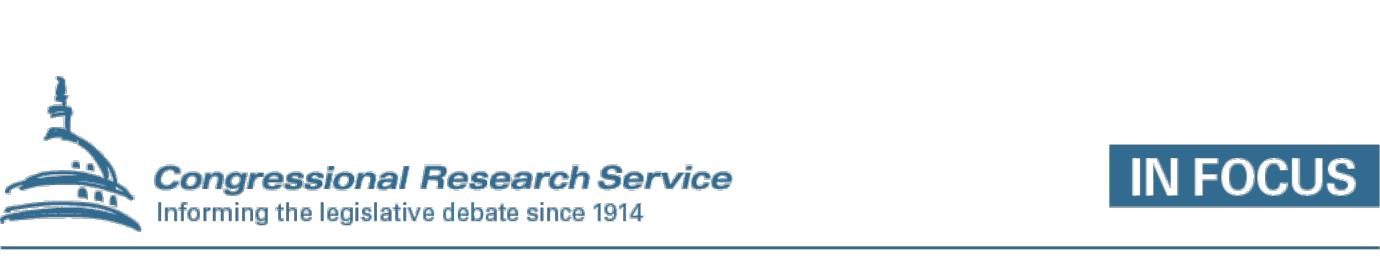

In [17]:
Image('./figures/figure-1-1.jpg')

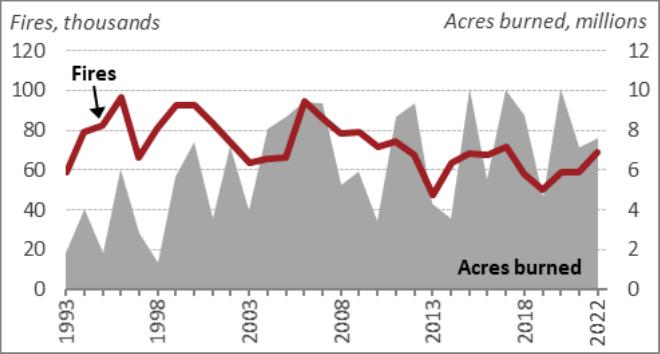

In [18]:
Image('./figures/figure-1-2.jpg')

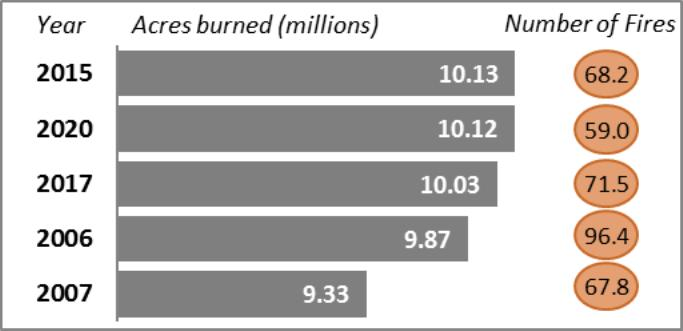

In [19]:
Image('./figures/figure-1-3.jpg')

In [20]:
multi_modal_llm = ChatOpenAI(model_name='gpt-4o', temperature=0)

In [21]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text particularly for semantic retrieval.
These summaries will be embedded and used to retrieve the raw text or table elements
Give a detailed summary of the table or text below that is well optimized for retrieval.
For any tables also add in a one line description of what the table is about besides the summary.
Do not add additional words like Summary: etc.

Table or text chunk:
{element}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
summarize_chain = (
                    {"element": RunnablePassthrough()}
                      |
                    prompt
                      |
                    multi_modal_llm
                      |
                    StrOutputParser() # extracts the response as text and returns it as a string
)

# Initialize empty summaries
text_summaries = []
table_summaries = []

text_docs = [doc.page_content for doc in docs]
table_docs = [table.page_content for table in tables]

text_summaries = summarize_chain.batch(text_docs, {"max_concurrency": 5})
table_summaries = summarize_chain.batch(table_docs, {"max_concurrency": 5})



In [26]:
len(text_summaries), len(table_summaries)

(3, 2)

In [27]:
text_summaries[0]

'The table provides an overview of wildfire statistics in the United States, detailing the number of wildfires and acres burned annually from 1993 to 2022. Wildfires include unplanned fires from natural and human causes, with state and federal responsibilities delineated based on land ownership. The Forest Service and the Department of the Interior manage wildfire responses on federal lands. Data from the National Interagency Coordination Center (NICC) shows a slight decrease in the number of wildfires over the past 30 years, but an increase in the acreage burned. From 2000 to 2022, an average of 70,025 wildfires burned 7.0 million acres annually, compared to 78,600 fires and 3.3 million acres in the 1990s. Between 2013 and 2022, the average was 61,410 wildfires and 7.2 million acres annually. In 2022, 68,988 wildfires burned 7.6 million acres, with over 40% of the acreage in Alaska. As of June 1, 2023, 18,300 wildfires have burned over 511,000 acres. Data includes wildfires on both fe

In [28]:
table_summaries[0]

'The table provides data on the number of fires and acres burned from 2018 to 2022, categorized by federal and nonfederal sources. For the number of fires, federal sources include FS (Forest Service), Dol, and Other, with totals ranging from 50.5 thousand in 2019 to 69.0 thousand in 2022. Notably, FS reported a significant increase in 2022 with 59 thousand fires. Nonfederal fires ranged from 39.6 thousand in 2019 to 45.0 thousand in 2021, with an anomaly in 2022 marked as $7.2. For acres burned, federal sources show a peak in 2020 with 7.1 million acres, while FS reported a dramatic increase in 2020 with 48 million acres. Nonfederal acres burned varied, with a notable entry marked as "Lg" in 2021. Total acres burned peaked in 2020 at 10.1 million. The table highlights trends and anomalies in fire occurrences and their impact over the five-year period.'

### Image summaries

We will use [GPT-4o](https://openai.com/index/hello-gpt-4o/) to produce the image summaries.

* We pass base64 encoded images

In [25]:
def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""

    msg = multi_modal_llm.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval.
                Remember these images could potentially contain graphs, charts or tables also.
                These summaries will be embedded and used to retrieve the raw image for question answering.
                Give a detailed summary of the image that is well optimized for retrieval.
                Do not add additional words like Summary: etc.
             """

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


# Image summaries
IMG_PATH = './figures'
imgs_base64, image_summaries = generate_img_summaries(IMG_PATH)

In [29]:
len(imgs_base64), len(image_summaries)

(5, 5)

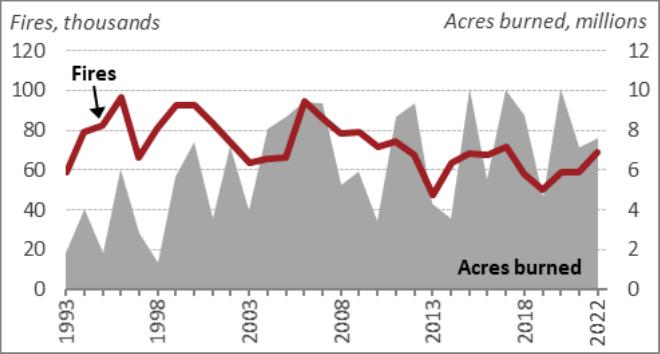

In [30]:
display(Image('./figures/figure-1-2.jpg'))

In [31]:
imgs_base64[1]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFiApQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD1Pw74d0i78PWU89hDJK8eWYg5JzWp/wAIroX/AEDIPyNHhX/kVtO/65D+Zq/fahZ6bb/aL65it4c43ysFGfqaAKH/AAiuhf8AQMg/I0f8IroX/QMg/I1PY6/pGpO6WOpWtwyDcwilDYHqcVbtrqC8gWe2mSaJujocg0AZv/C

In [32]:
image_summaries[1]

'Line and area chart depicting the number of fires and acres burned in the United States from 1993 to 2022. The left y-axis represents the number of fires in thousands, while the right y-axis shows acres burned in millions. The x-axis spans the years 1993 to 2022. A red line indicates the number of fires, peaking around 1996 and 2006, with fluctuations throughout the period. A grey shaded area represents acres burned, showing peaks around 2006, 2012, and 2017. The chart highlights a general trend of fluctuating fire occurrences and acres burned over the years.'

### Add to vectorstore

Add raw docs and doc summaries to [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary):

* Store the raw texts, tables, and images in the `docstore` (here we are using Redis).
* Store the texts, table summaries, and image summaries in the `vectorstore` (here we are using Chroma) for efficient semantic retrieval.

In [ ]:
%%sh
curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg
echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/redis.list
sudo apt-get update  > /dev/null 2>&1
sudo apt-get install redis-stack-server  > /dev/null 2>&1
redis-stack-server --daemonize yes

### Open AI Embedding Models

LangChain enables us to access Open AI embedding models which include the newest models: a smaller and highly efficient `text-embedding-3-small` model, and a larger and more powerful `text-embedding-3-large` model.

In [33]:
# details here: https://openai.com/blog/new-embedding-models-and-api-updates
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

In [155]:
docs[0]

b'a. aa = Informing the legislative debate since 1914 Congressional Research Service\n\nUpdated June 1, 2023\n\nWildfire Statistics\n\nWildfires are unplanned fires, including lightning-caused fires, unauthorized human-caused fires, and escaped fires from prescribed burn projects. States are responsible for responding to wildfires that begin on nonfederal (state, local, and private) lands, except for lands protected by federal agencies under cooperative agreements. The federal government is responsible for responding to wildfires that begin on federal lands. The Forest Service (FS)\xe2\x80\x94within the U.S. Department of Agriculture\xe2\x80\x94carries out wildfire management and response across the 193 million acres of the National Forest System (NFS). The Department of the Interior (DOI) manages wildfire response for more than 400 million acres of national parks, wildlife refuges and preserves, other public lands, and Indian reservations.\n\nFigure 1. Annual Wildfires and Acres Burne

In [34]:
def create_multi_vector_retriever(
    docstore, vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """


    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=docstore,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries and their embeddings
chroma_db = Chroma(
    collection_name="mm_rag",
    embedding_function=openai_embed_model,
    collection_metadata={"hnsw:space": "cosine"},
)

# Initialize the storage layer - to store raw images, text and tables
client = get_client('redis://localhost:6379')
redis_store = RedisStore(client=client) # you can use filestore, memorystory, any other DB store also

# Create retriever
retriever_multi_vector = create_multi_vector_retriever(
    redis_store,
    chroma_db,
    text_summaries,
    text_docs,
    table_summaries,
    table_docs,
    image_summaries,
    imgs_base64,
)

In [35]:
retriever_multi_vector

MultiVectorRetriever(vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x7cfd0e53f230>, docstore=<langchain_community.storage.redis.RedisStore object at 0x7cfd0e315fd0>, search_kwargs={})

### Utilities to separate retrieved elements

We need to bin the retrieved doc(s) into the correct parts of the GPT-4o prompt template.

Here we need to have text, table elements as one set of inputs and image elements as the other set of inputs as both require separate prompts in GPT-4o.

In [36]:
def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content.decode('utf-8')
        else:
            doc = doc.decode('utf-8')
        if looks_like_base64(doc) and is_image_data(doc):
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}

In [37]:
# Check retrieval
query = "Tell me detailed statistics of the top 5 years with largest wildfire acres burned"
docs = retriever_multi_vector.invoke(query, limit=5)

# We get 4 docs
len(docs)

4

In [38]:
r = split_image_text_types(docs)
r

{'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFLAqsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0Dwx4Y07WdHF7eiVp2kYEiTGcVs/8IHon9yf/AL+mjwH/AMiyn/XV/wCddNQBzP8Awgeif3J/+/po/wCED0T+5P8A9/TXTUUAcz/wgeif3J/+/po/4QPRP7k//f010rMqKWdgqjqScAUKysoZWBU8gg8UAc1

In [39]:
def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Decode the base64 string
    img_data = base64.b64decode(img_base64)
    # Create a BytesIO object
    img_buffer = BytesIO(img_data)
    # Open the image using PIL
    img = PILImage.open(img_buffer)
    display(img)

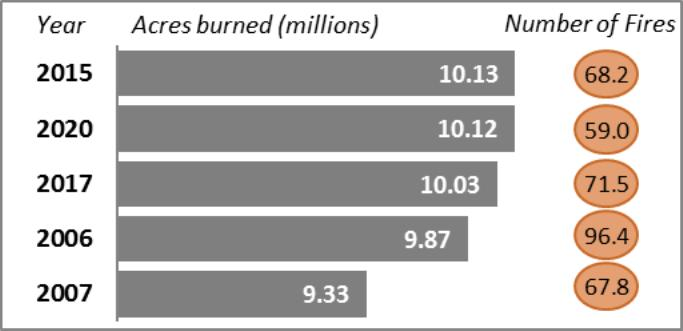

In [40]:
for i in range(len(r['images'])):
    plt_img_base64(r['images'][i])

## Multimodal RAG

### Build End-to-End Multimodal RAG Pipeline

Now let's connect our retriever, prompt instructions and build a multimodal RAG chain

In [41]:
from operator import itemgetter
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.messages import HumanMessage

def multimodal_prompt_function(data_dict):
    """
    Create a multimodal prompt with both text and image context.

    This function formats the provided context from `data_dict`, which contains
    text, tables, and base64-encoded images. It joins the text (with table) portions
    and prepares the image(s) in a base64-encoded format to be included in a message.

    The formatted text and images (context) along with the user question are used to
    construct a prompt for GPT-4o
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            f"""You are an analyst tasked with understanding detailed information and trends from text documents,
                data tables, and charts and graphs in images.
                You will be given context information below which will be a mix of text, tables, and images usually of charts or graphs.
                Use this information to provide answers related to the user question.
                Do not make up answers, use the provided context documents below and answer the question to the best of your ability.

                User question:
                {data_dict['question']}

                Context documents:
                {formatted_texts}

                Answer:
            """
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


# Create RAG chain
multimodal_rag = (
        {
            "context": itemgetter('context'),
            "question": itemgetter('input'),
        }
            |
        RunnableLambda(multimodal_prompt_function)
            |
        multi_modal_llm
            |
        StrOutputParser()
)

# Pass input query to retriever and get context document elements
retrieve_docs = (itemgetter('input')
                    |
                retriever_multi_vector
                    |
                RunnableLambda(split_image_text_types))

# Below, we chain `.assign` calls. This takes a dict and successively
# adds keys-- "context" and "answer"-- where the value for each key
# is determined by a Runnable (function or chain executing at runtime).
# This helps in also having the retrieved context along with the answer generated by GPT-4o
multimodal_rag_w_sources = (RunnablePassthrough.assign(context=retrieve_docs)
                                               .assign(answer=multimodal_rag)
)

In [42]:
# Run RAG chain
query = "Tell me detailed statistics of the top 5 years with largest wildfire acres burned"
response = multimodal_rag_w_sources.invoke({'input': query})
response

{'input': 'Tell me detailed statistics of the top 5 years with largest wildfire acres burned',
 'context': {'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFLAqsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0Dwx4Y07WdHF7eiVp2kYEiTGcVs/8IHon9yf/AL+mjwH/AMiy

In [43]:
def multimodal_rag_qa(query):
    response = multimodal_rag_w_sources.invoke({'input': query})
    print('=='*50)
    print('Answer:')
    display(Markdown(response['answer']))
    print('--'*50)
    print('Sources:')
    text_sources = response['context']['texts']
    img_sources = response['context']['images']
    for text in text_sources:
        display(Markdown(text))
        print()
    for img in img_sources:
        plt_img_base64(img)
        print()
    print('=='*50)

Answer:


Based on the provided data, here are the detailed statistics for the top 5 years with the largest wildfire acres burned:

1. **2015**
   - Acres Burned: 10.13 million
   - Number of Fires: 68.2 thousand

2. **2020**
   - Acres Burned: 10.12 million
   - Number of Fires: 59.0 thousand

3. **2017**
   - Acres Burned: 10.03 million
   - Number of Fires: 71.5 thousand

4. **2006**
   - Acres Burned: 9.87 million
   - Number of Fires: 96.4 thousand

5. **2007**
   - Acres Burned: 9.33 million
   - Number of Fires: 67.8 thousand

These statistics reflect the years with the highest acreage burned due to wildfires, indicating significant wildfire activity during these periods.

----------------------------------------------------------------------------------------------------
Sources:


a. aa = Informing the legislative debate since 1914 Congressional Research Service

Updated June 1, 2023

Wildfire Statistics

Wildfires are unplanned fires, including lightning-caused fires, unauthorized human-caused fires, and escaped fires from prescribed burn projects. States are responsible for responding to wildfires that begin on nonfederal (state, local, and private) lands, except for lands protected by federal agencies under cooperative agreements. The federal government is responsible for responding to wildfires that begin on federal lands. The Forest Service (FS)—within the U.S. Department of Agriculture—carries out wildfire management and response across the 193 million acres of the National Forest System (NFS). The Department of the Interior (DOI) manages wildfire response for more than 400 million acres of national parks, wildlife refuges and preserves, other public lands, and Indian reservations.

Figure 1. Annual Wildfires and Acres Burned, 1993-2022

Acres burned, millions Fires, thousands 120 Fires 100 \

Wildfire statistics help illustrate past U.S. wildfire activity. Nationwide data compiled by the National Interagency Coordination Center (NICC) indicate that the number of annual wildfires is variable but has decreased slightly over the last 30 years. The number of acres affected annually, while also variable, generally has increased (see Figure 1). Since 2000, an annual average of 70,025 wildfires have burned an annual average of 7.0 million acres. The acreage figure is more than double the average annual acreage burned in the 1990s (3.3 million acres), although a greater number of fires occurred annually in the 1990s on average (78,600).

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: Data reflect wildland fires and acres burned nationwide, including wildland fires on federal and nonfederal lands.

From 2013 to 2022, there were an average of 61,410 wildfires annually and an average of 7.2 million acres impacted annually. In 2022, 68,988 wildfires burned 7.6 million acres. Over 40% of those acres were in Alaska (3.1 million acres).

As of June 1, 2023, around 18,300 wildfires have impacted over 511,000 acres this year.

|  | 2018 | 2019 | 2020 | 2021 | 2022 |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Number of Fires (thousands) |
| Federal | 12.5 | 10.9 | 14.4 | 14.0 | 11.7 |
| FS | 5.6 | 5.3 | 6.7 | 6.2 | 59 |
| Dol | 7.0 | 5.3 | 7.6 | 7.6 | 5.8 |
| Other | 0.1 | 0.2 | &lt;0.1 | 0.2 | 0.1 |
| Nonfederal | 45.6 | 39.6 | 44.6 | 45.0 | $7.2 |
| Total | 58.1 | 50.5 | 59.0 | 59.0 | 69.0 |
| Acres Burned (millions) |
| Federal | 4.6 | 3.1 | 7.1 | 5.2 | 40 |
| FS | 2.3 | 0.6 | 48 | 41 | 19 |
| Dol | 2.3 | 2.3 | 2.3 | 1.0 | 2.1 |
| Other | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 |
| Nonfederal | 4.1 | 1.6 | 3.1 | Lg | 3.6 |
| Total | 8.8 | 4.7 | 10.1 | 7.1 | 7.6 |


Resources

Another metric useful for assessing wildfire activity is the extent to which nationwide resources—including personnel and equipment—are engaged in wildfire suppression. A proxy for resource commitments is the nationwide Preparedness Level (PL) scale, which ranges from 1 (lowest) to 5 (highest). The higher PLs indicate significant commitment of shared resources. In 2022, the nationwide level was 4 for 10 days and never reached the highest level (5). In contrast, the highest level was reached for 68 days in 2021, the longest since at least 2000.

Wildfire Damages

Figure 3. Percentage Acreage Burned by Ownership

100% __ Non- federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2020 2021 2022

Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the majority of the damage occurred in California (see Table 2).

Table 2. Loss Statistics

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: DOI = Department of the Interior.

More wildfires occur in the East (including the central states), but the wildfires in the West (i.e., Alaska, Arizona, California, Colorado, Idaho, Montana, New Mexico, Nevada, Oregon, Utah, Washington, and Wyoming) are larger and burn more acreage. In 2022, just over 20,000 wildfires burned approximately 5.8 million acres in the West, compared with the over 48,000 fires that burned just over 1.8 million acres in the East. In the East (where there is less federal acreage), most of the fires occur on nonfederal lands; in the West, most of the fires occur on federal lands (see Figure 4). In 2022, 85% (1.5 million acres) of the acreage burned in the East was on nonfederal land, whereas 64% (3.7 million acres) of the acreage burned in the West was on federal land.

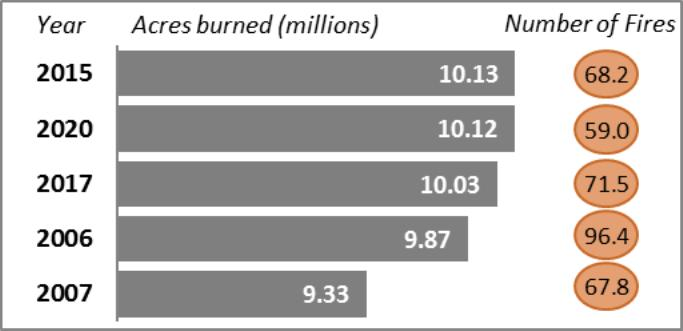

In [47]:
query = "Tell me detailed statistics of the top 5 years with largest wildfire acres burned"
multimodal_rag_qa(query)

In [ ]:
# Run RAG chain
query = "Tell me about the percentage of residences burned by wildfires in 2022"
multimodal_rag_qa(query)

Answer:


In 2022, 46% of the structures burned by wildfires were residences. This percentage is consistent with the percentage of residences burned in 2019, which was also 46%.

----------------------------------------------------------------------------------------------------
Sources:


|  | 2019 | 2020 | 2021 | 2022 |
| :--- | :--- | :--- | :--- | :--- |
| Structures Burned | 963 | 17,904 | 5,972 | 2,717 |
| % Residences | 46% | 54% | 60% | 46% |


a. aa = Informing the legislative debate since 1914 Congressional Research Service

Updated June 1, 2023

Wildfire Statistics

Wildfires are unplanned fires, including lightning-caused fires, unauthorized human-caused fires, and escaped fires from prescribed burn projects. States are responsible for responding to wildfires that begin on nonfederal (state, local, and private) lands, except for lands protected by federal agencies under cooperative agreements. The federal government is responsible for responding to wildfires that begin on federal lands. The Forest Service (FS)—within the U.S. Department of Agriculture—carries out wildfire management and response across the 193 million acres of the National Forest System (NFS). The Department of the Interior (DOI) manages wildfire response for more than 400 million acres of national parks, wildlife refuges and preserves, other public lands, and Indian reservations.

Figure 1. Annual Wildfires and Acres Burned, 1993-2022

Acres burned, millions Fires, thousands 120 Fires 100 \

Wildfire statistics help illustrate past U.S. wildfire activity. Nationwide data compiled by the National Interagency Coordination Center (NICC) indicate that the number of annual wildfires is variable but has decreased slightly over the last 30 years. The number of acres affected annually, while also variable, generally has increased (see Figure 1). Since 2000, an annual average of 70,025 wildfires have burned an annual average of 7.0 million acres. The acreage figure is more than double the average annual acreage burned in the 1990s (3.3 million acres), although a greater number of fires occurred annually in the 1990s on average (78,600).

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: Data reflect wildland fires and acres burned nationwide, including wildland fires on federal and nonfederal lands.

From 2013 to 2022, there were an average of 61,410 wildfires annually and an average of 7.2 million acres impacted annually. In 2022, 68,988 wildfires burned 7.6 million acres. Over 40% of those acres were in Alaska (3.1 million acres).

As of June 1, 2023, around 18,300 wildfires have impacted over 511,000 acres this year.

Resources

Another metric useful for assessing wildfire activity is the extent to which nationwide resources—including personnel and equipment—are engaged in wildfire suppression. A proxy for resource commitments is the nationwide Preparedness Level (PL) scale, which ranges from 1 (lowest) to 5 (highest). The higher PLs indicate significant commitment of shared resources. In 2022, the nationwide level was 4 for 10 days and never reached the highest level (5). In contrast, the highest level was reached for 68 days in 2021, the longest since at least 2000.

Wildfire Damages

Figure 3. Percentage Acreage Burned by Ownership

100% __ Non- federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2020 2021 2022

Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the majority of the damage occurred in California (see Table 2).

Table 2. Loss Statistics

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: DOI = Department of the Interior.

More wildfires occur in the East (including the central states), but the wildfires in the West (i.e., Alaska, Arizona, California, Colorado, Idaho, Montana, New Mexico, Nevada, Oregon, Utah, Washington, and Wyoming) are larger and burn more acreage. In 2022, just over 20,000 wildfires burned approximately 5.8 million acres in the West, compared with the over 48,000 fires that burned just over 1.8 million acres in the East. In the East (where there is less federal acreage), most of the fires occur on nonfederal lands; in the West, most of the fires occur on federal lands (see Figure 4). In 2022, 85% (1.5 million acres) of the acreage burned in the East was on nonfederal land, whereas 64% (3.7 million acres) of the acreage burned in the West was on federal land.

|  | 2018 | 2019 | 2020 | 2021 | 2022 |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Number of Fires (thousands) |
| Federal | 12.5 | 10.9 | 14.4 | 14.0 | 11.7 |
| FS | 5.6 | 5.3 | 6.7 | 6.2 | 59 |
| Dol | 7.0 | 5.3 | 7.6 | 7.6 | 5.8 |
| Other | 0.1 | 0.2 | &lt;0.1 | 0.2 | 0.1 |
| Nonfederal | 45.6 | 39.6 | 44.6 | 45.0 | $7.2 |
| Total | 58.1 | 50.5 | 59.0 | 59.0 | 69.0 |
| Acres Burned (millions) |
| Federal | 4.6 | 3.1 | 7.1 | 5.2 | 40 |
| FS | 2.3 | 0.6 | 48 | 41 | 19 |
| Dol | 2.3 | 2.3 | 2.3 | 1.0 | 2.1 |
| Other | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 |
| Nonfederal | 4.1 | 1.6 | 3.1 | Lg | 3.6 |
| Total | 8.8 | 4.7 | 10.1 | 7.1 | 7.6 |
